In [17]:
# import sys
# sys.path.append('../')

from data_loader import load_datasets
from data_partitioner import partition_train_data, PartitionStrategy
from fleet_aggregation import BaseStrategy
from models import Net
from utilities import train, test, get_parameters, set_parameters
from zod_dataset import ZodDataset
import matplotlib as plt
import torch
import random
from zod import ZodFrames
from zod import constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks.early_stopping import EarlyStopping




In [18]:

# GPU
device = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"{device} is aviable")


cuda is aviable


# SETTINGS 

In [19]:
NO_CLIENTS = 40 #40
CLIENTS_PER_ROUND = 5 #10
PERCENT_DATA = 1
GLOBAL_ROUNDS = 40 #40

FILE_NAME = f"t_loc_{NO_CLIENTS}_{CLIENTS_PER_ROUND}_{int(PERCENT_DATA * 100)}"
PLOT_NAME = f"t_plt_loc_{NO_CLIENTS}_{CLIENTS_PER_ROUND}_{int(PERCENT_DATA * 100)}"

LOAD_FILE_NAME = "loc_40_5_100_7.npz"


def select_client(clients):
    return random.sample(clients,CLIENTS_PER_ROUND)

print("Working")

Working


LOAD PARAMETERS AND MODEL

In [20]:
new_net = Net().to(device)  # create a new instance of the model

# Loading the saved parameters to a new model
loaded_data_main = np.load(f'SAVED_PARAMS/{LOAD_FILE_NAME}', allow_pickle=True) 
loaded_params_main = loaded_data_main['arr_0']
set_parameters(new_net, loaded_params_main)



Set model parameters


LOAD DATA

In [21]:
def setup():
    global testloader, clients, partitions, device, strategy, round_test_losses, zod_frames, round_train_losses
    # GPU
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )
    print(f"{device} is aviable")

    # Pictures
    zod_frames = ZodFrames("/mnt/ZOD", version="full") # full
    strategy = BaseStrategy()
    net = Net().to(device)  # create a new instance of the model
    clients = [str(i) for i in range(NO_CLIENTS)]

    
    partitions = partition_train_data(
        PartitionStrategy.LOCATION,
        NO_CLIENTS,
        zod_frames,
        PERCENT_DATA,
    )

# testloader is a class that can be used to iterate over a dataset'
    _, testloader = load_datasets(zod_frames.get_split(constants.VAL), zod_frames)
    print(len(testloader))
    round_test_losses = []
    round_train_losses = []
    return testloader, clients, partitions, device, strategy, round_test_losses, zod_frames, round_train_losses
setup()

cuda is aviable


Loading infos: 0it [00:00, ?it/s]

loaded stored ground truth


/home/edgelab/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


{'0': ['049104', '038597', '010943', '038961', '021956', '023274', '036225', '031107', '012310', '035762', '044577', '050265', '027206', '039343', '039546', '035452', '032459', '022208', '019882', '019711', '043730', '048353', '032327', '035756', '019188', '034854', '027583', '010941', '020305', '050777', '024246', '046190', '048165', '045980', '044508', '010562', '096463', '020655', '013758', '022493', '032227', '018438', '013536', '039204', '039604', '049853', '083394', '011681', '024309', '009601', '037282', '043259', '015640', '029986', '019721', '040176', '036433', '028637', '046548', '047170', '046722', '036874', '043292', '035212', '035343', '017235', '010866', '038878', '017973', '028060', '024358', '028650', '042850', '027018', '038384', '040790', '048605', '045475', '041767', '036887', '050583', '040437', '034507', '036329', '024826', '036743', '030760', '014234', '012091', '023828', '029233', '043255', '028909', '033504', '039947', '036303', '048174', '042406', '031987', '03

(<torch.utils.data.dataloader.DataLoader at 0x7ff2630aa200>,
 ['0',
  '1',
  '2',
  '3',
  '4',
  '5',
  '6',
  '7',
  '8',
  '9',
  '10',
  '11',
  '12',
  '13',
  '14',
  '15',
  '16',
  '17',
  '18',
  '19',
  '20',
  '21',
  '22',
  '23',
  '24',
  '25',
  '26',
  '27',
  '28',
  '29',
  '30',
  '31',
  '32',
  '33',
  '34',
  '35',
  '36',
  '37',
  '38',
  '39'],
 {'0': ['049104',
   '038597',
   '010943',
   '038961',
   '021956',
   '023274',
   '036225',
   '031107',
   '012310',
   '035762',
   '044577',
   '050265',
   '027206',
   '039343',
   '039546',
   '035452',
   '032459',
   '022208',
   '019882',
   '019711',
   '043730',
   '048353',
   '032327',
   '035756',
   '019188',
   '034854',
   '027583',
   '010941',
   '020305',
   '050777',
   '024246',
   '046190',
   '048165',
   '045980',
   '044508',
   '010562',
   '096463',
   '020655',
   '013758',
   '022493',
   '032227',
   '018438',
   '013536',
   '039204',
   '039604',
   '049853',
   '083394',
   '011681',

# TRAIN | MAIN CODE

In [22]:
def main() -> None:  
    early_stopping = False

    for round in range(1, GLOBAL_ROUNDS+1):
        if early_stopping:
            break

        print("ROUND", round)
        selected = select_client(clients)
        nets = []
        
        for client_idx in selected:
            
            net_copy = new_net.to(device) 

            net_copy.load_state_dict(new_net.state_dict()) 
            net_copy.train()
    
            trainloader, valloader = load_datasets(partitions[str(client_idx)], zod_frames)

            epoch_train_losses, epoch_val_losses = train(net_copy, trainloader, valloader, epochs=5)
            print(f"Client: {client_idx:>2} Train losses: {epoch_train_losses}, Val losses: {epoch_val_losses}")
            
            nets.append((get_parameters(net_copy), 1))


        agg_weights = strategy.aggregate_fit_fedavg(nets)
        
        set_parameters(new_net, agg_weights[0])

        new_net.eval()
        batch_test_losses = []
        batch_train_losses = []

        for data, target in testloader:
            data, target = data.to(device), target.to(device)
            pred = new_net(data)
            batch_test_losses.append(new_net.loss_fn(pred, target).item())

        batch_train_losses.append(sum(epoch_train_losses)/len(epoch_train_losses))


        round_test_losses.append(sum(batch_test_losses)/len(batch_test_losses))
        round_train_losses.append(sum(batch_train_losses)/len(batch_train_losses))

        # EARLY STOPPING
        train_cunt = 0
        if round > 1:
            if int(abs(round_train_losses[-1] - round_train_losses[-2])) <= 0.1:
                train_cunt += 1
                if train_cunt == 4:
                    early_stopping = True
                else: 
                    train_cunt = 0

        test_cunt = 0
        if round > 1:  
            if int(round_test_losses[-1] - round_test_losses[-2]) > 0.15:  
                test_cunt += 1
                if test_cunt == 4:
                    early_stopping = True  
                else:
                    test_cunt = 0
                
    
        print(f"Test loss: {round_test_losses[-1]}")
        print(f"Training loss: {round_train_losses[-1]}")


    print('==========================================================')
    print(round_test_losses,'TEST')
    print(round_train_losses,'TRAIN') 
    print('==========================================================')


        # SAVE PARAMS
    length_of_round = len(round_test_losses)

    model_params = get_parameters(new_net)
    model_params = np.array(model_params, dtype=object)
    filename = f"{FILE_NAME}_{length_of_round}.npz"
    np.savez(filename, model_params)

if __name__ == "__main__":

    main()

ROUND 1
611
5505
Client: 10 Train losses: [2.5225111032496987, 2.3989903727018764, 2.601366739397104, 2.295710917497646, 2.2466399521496943], Val losses: [(2.5110680162906647, None), (2.607225424051285, None), (2.87272624373436, None), (2.6472902953624726, None), (2.5417626440525054, None)]
⤺ Get model parameters
121
1098
Client: 35 Train losses: [3.0315307719366893, 2.463381474358695, 2.175417688914708, 2.188954748426165, 2.0069333689553397], Val losses: [(2.5188187062740326, None), (1.8595489263534546, None), (1.916532427072525, None), (2.1139504313468933, None), (2.1559855937957764, None)]
⤺ Get model parameters
71
646
Client: 33 Train losses: [1.8960067828496296, 1.661256233851115, 1.486443471340906, 1.3949321678706579, 1.3622743884722393], Val losses: [(1.166530927022298, None), (0.8290063937505087, None), (0.9717993140220642, None), (0.9737852215766907, None), (0.8819912870724996, None)]
⤺ Get model parameters
551
4965
Client: 12 Train losses: [2.708273463524305, 2.50884348039443

PLOT

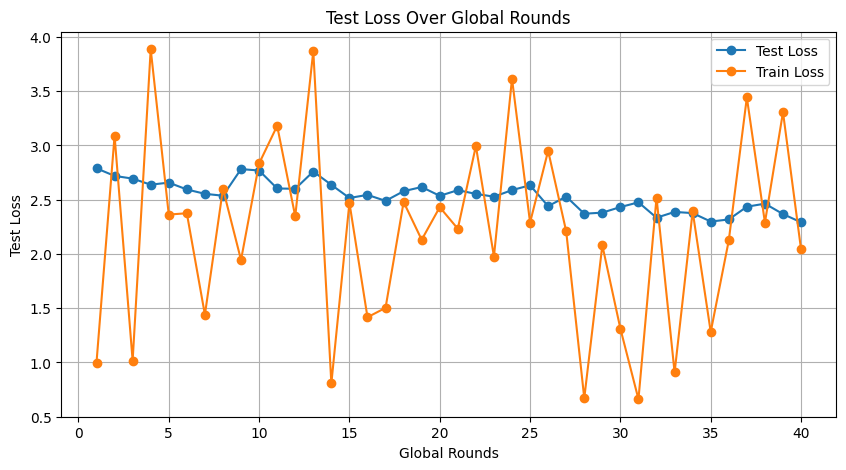

In [23]:
length_of_round = len(round_test_losses)

plt.figure(figsize=(10, 5))  
plt.plot(range(1, length_of_round + 1), round_test_losses, marker='o', linestyle='-', label='Test Loss')
plt.plot(range(1, length_of_round + 1), round_train_losses, marker='o', linestyle='-', label='Train Loss')
plt.title('Test Loss Over Global Rounds')
plt.xlabel('Global Rounds')
plt.ylabel('Test Loss')
plt.grid(True)
plt.legend() 
plt.savefig(f"{PLOT_NAME}_{length_of_round}.png")



In [24]:
round_test_losses.clear()
round_train_losses.clear()